# Spam Filtering Techniques for Short Message Service
## EPFL - Adaptation and Learning (EE-621) 
## Adrien Besson and Dimitris Perdios

This notebook illustrates the process used to train and test a classifier for spam filtering.
We focus on logistic regression but the script can be easily adapted to any other classifier.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix
import sklearn.linear_model as lm
import utils as ut
import matplotlib.pyplot as plt
import os

[sklearn feature extraction from text]: http://scikit-learn.org/stable/modules/feature_extraction.html#text-feature-extraction 
[tf-idf]:https://en.wikipedia.org/wiki/Tf%E2%80%93idf 
[bag-of-words]:https://en.wikipedia.org/wiki/Bag-of-words_model

### 1.  Feature extraction

In the feature extraction process, we use the [bag-of-words] model followed by term-frequency inverse-document-frequency ([tf-idf]) weighting which are standard in natural language processing.
They are well documented on the [sklearn feature extraction from text] page.

In [2]:
# Load dataset
input_file = os.path.join(os.pardir, 'datasets', 'spam.csv')
data = pd.read_csv(input_file, encoding='latin_1', usecols=[0, 1])

# Rename the columns with more explicit names
data.rename(columns={'v1' : 'label', 'v2' : 'message'}, inplace=True)

# Convert labels into 0 and 1
data['class'] = data.label.map({'ham':0, 'spam':1})

We split the dataset into a training and a test set, with a 80/20 split

In [3]:
# Create a training set and a test set
train, test = train_test_split(data, train_size=0.8, test_size=0.2, random_state=10)

We extract the matrix of occurences using the [CountVectorizer] class of [sklearn].
Once the vectrorizer is created, we fit the model on the training set and use it to transform the test set.
During the fitting step of the model, a vocabulary is learned from the training set.

[CountVectorizer]: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
[sklearn]: http://scikit-learn.org/stable/

In [4]:
# Create a CountVectorizer Object
vectorizer = CountVectorizer(encoding='latin-1', stop_words='english') # stop_words = english removes the main stop words (may be it can be good to test it)

# Fit the vectorizer object
X_train = vectorizer.fit_transform(train['message'])

# Transform the test set
X_test = vectorizer.transform(test['message'])

We apply tf-idf weighting using the [TfidfTransformer] of sklearn. Again we create the object, fit on the training set and transform the test set.

[TfidfTransformer]: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html

In [5]:
# Create a TfIdf Transformer object
transformer = TfidfTransformer(norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)

# Fit the model to the training set
features_train = transformer.fit_transform(X_train)

# Transform the test set
features_test = transformer.transform(X_test)

# Create labels
labels_train = train['class']
labels_test = test['class']

### 2. Fitting and testing the model

To fit the model, we again rely on sklearn. The best hyper-parameters are identified using 10-fold cross validation on the training set and the misclassification error is then calculated on the test set.

In [6]:
# Create the logistic regression model
lrl2  = lm.LogisticRegression(penalty='l2', solver='liblinear', random_state=10)

# Create the 10-fold cross-validation model
gs_steps = 10
n_jobs = -1
cv=10
lr_param = {'C': np.logspace(-4, 9, gs_steps)}
lrl2_gscv = GridSearchCV(lrl2, lr_param, cv=10, n_jobs=n_jobs)

# Fit the cross-validation model
lrl2_gscv.fit(X=features_train, y=labels_train)
score_lrl2 = lrl2_gscv.score(X=features_test, y=labels_test)
print('Misclassification error: {0} %'.format((1-score_lrl2)*100))

Misclassification error: 1.4349775784753382 %


### 3. Confusion matrix
Confusion matrices are useful to analyze the sensitivity/specificity of a classifier.
In our case, it is of great interest since the dataset is imbalanced.
Here is a script that plots the confusion matrix of the proposed regularized logistic regression classifier.

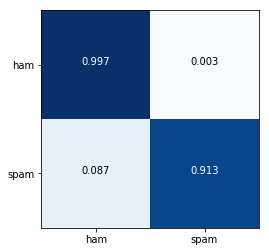

Sensitivity: 0.913 
Specificity: 0.997


In [7]:
# Compute the confusion matrix
preds_test = lrl2_gscv.best_estimator_.predict(features_test)
cm = confusion_matrix(y_true=labels_test, y_pred=preds_test)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

# Display the confusion matrix
classes = ['ham', 'spam']
digits = 3
ut.plot_confusion_matrix(cm, classes=classes, digits=digits)
plt.show()

# Show sensitivity and specificity
specificity = cm[0, 0] / np.sum(cm[0])
sensitivity = cm[1, 1] / np.sum(cm[1])
print('Sensitivity: {0:.3f} \nSpecificity: {1:.3f}'.format(sensitivity, specificity))